## Import Modules and Data

In [149]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.grid_search import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [150]:
np.random.seed(42)

In [151]:
train_df = pd.read_csv('./data/train_modeling.csv', index_col='Id')
test_df = pd.read_csv('./data/test_modeling.csv', index_col='Id')

## Pre-scaling

In [152]:
lr = LinearRegression()

In [153]:
y = train_df['saleprice']
X = train_df[[col for col in train_df.columns if col != 'saleprice']]

lr.fit(X,y)

lr.predict(X)
lr.score(X,y)

0.94747744064565687

## Create Train/Test Split and Scale Data

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [155]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Set Up the Pipeline

In [156]:
pipe_lasso = Pipeline([
    ('ss', StandardScaler()),
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('lasso', Lasso())])

pipe_ridge = Pipeline([
    ('ss', StandardScaler()),
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('ridge', Ridge())])

pipe_el = Pipeline([
    ('ss', StandardScaler()), 
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('elastic', ElasticNet())])

pipe_linear = Pipeline([
    ('ss', StandardScaler()), 
    ('var_thresh', VarianceThreshold()),
    ('kbest', SelectKBest(f_regression)),
    ('linreg', LinearRegression())])

In [157]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'lasso__alpha': np.logspace(-3,3,7)}

My gridsearch has a variance threshold of 0.1 and is selecting the 20 best features using KBest.

**Drop saleprice from Train Data Set before GridSearch**

In [158]:
train_df.drop('saleprice', axis=1, inplace=True)

## Linear Model

In [159]:
y_train.mean()

12.021720682743458

In [160]:
params = {}
gs_linreg = GridSearchCV(pipe_linear, params)
gs_linreg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x10bde8268>)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [161]:
gs_linreg.score(X_train, y_train)

0.86312648607711795

In [162]:
gs_linreg.score(X_test, y_test)

0.88070963001058655

In [163]:
np.sqrt(mean_squared_error(y_test, gs_linreg.predict(X_test)))

0.14231203843096904

In [164]:
gs_linreg.best_score_

0.859085699925934

This seems to be a pretty god R2 score.  This means that the model explains 85.9% of the variability of the response data around the mean.

In [165]:
gs_linreg_best_var_thresh = gs_linreg.best_estimator_.named_steps['var_thresh'].get_support()

In [166]:
gs_linreg_best_kbest = gs_linreg.best_estimator_.named_steps['kbest'].get_support()

In [167]:
gs_linreg_best_estimator = gs_linreg.best_estimator_.named_steps['linreg'].coef_

In [168]:
np.sqrt(mean_squared_error(y_test, gs_linreg.best_estimator_.predict(X_test)))

0.14231203843096904

In [169]:
gs_linreg_prediction_test = gs_linreg.predict(X_test)

Text(0,0.5,'Actual Values')

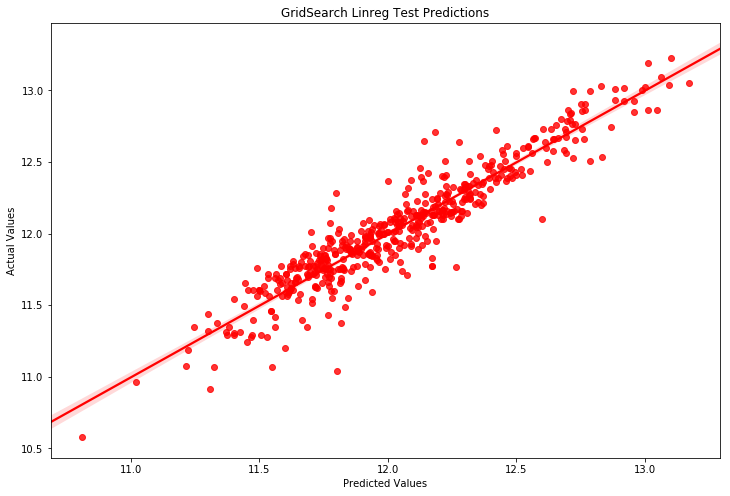

In [170]:
plt.figure(figsize=(12,8))
sns.regplot(gs_linreg_prediction_test, y_test, color='red')
plt.title("GridSearch Linreg Test Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

In [171]:
columns = train_df.columns
columns = columns[gs_linreg.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_linreg.best_estimator_.named_steps['kbest'].get_support()]

linreg_df = pd.DataFrame(gs_linreg.best_estimator_.named_steps['linreg'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

linreg_df

,Coef Weights
overall_qual,0.128517
year_built,0.047660
year_remod/add,0.041362
gr_liv_area,0.030765
garage_yr_blt,-0.005652
garage_area,0.051998
total_area,0.141147
total_bath,0.028231
exter_qual_TA,0.016645
kitchen_qual_TA,-0.011583


In [172]:
beta_0 = gs_linreg.best_estimator_.named_steps['linreg'].intercept_

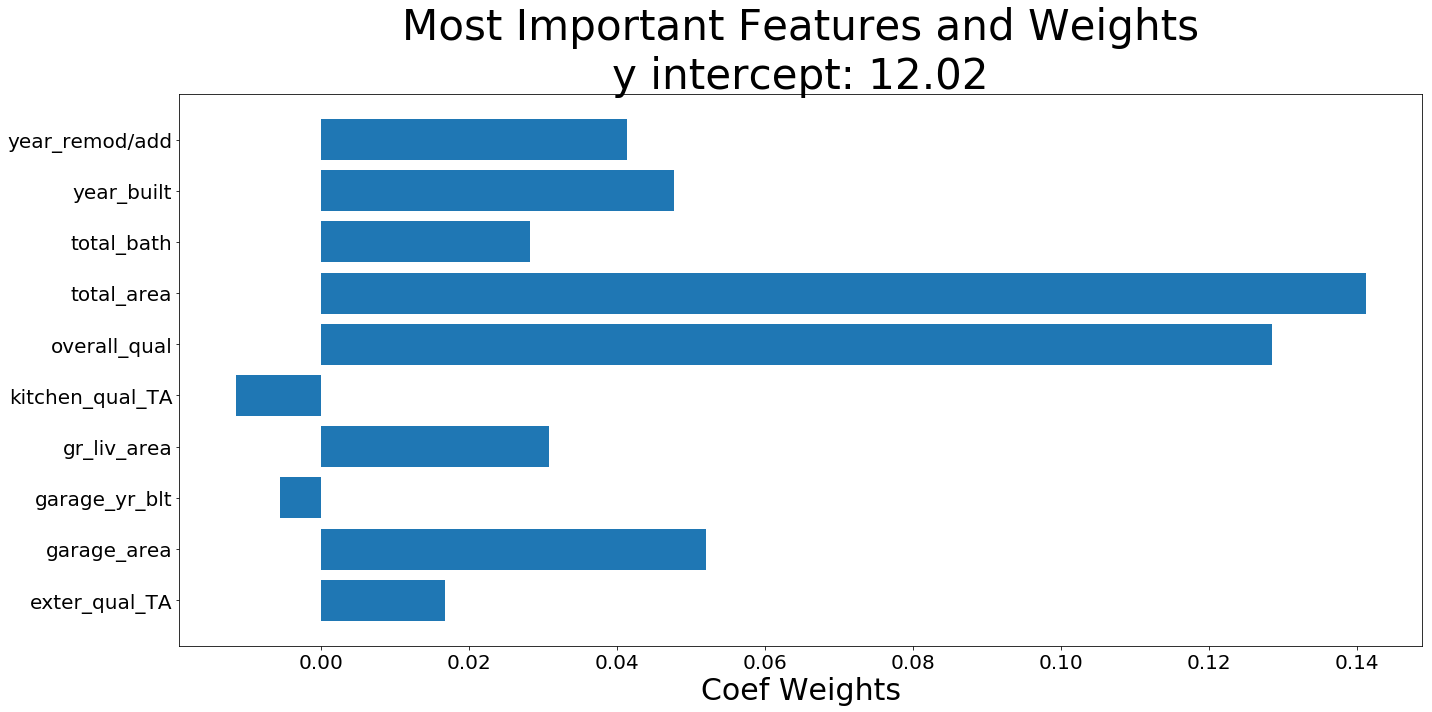

In [173]:
plt.figure(figsize=(20,10))
plt.barh(linreg_df.index, linreg_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=42)
plt.tight_layout()

## Lasso

I will try a lasso model to see if it can deal with any potential multicollinearity between variables.  lasso is especially useful when there are redundant or unimportant variables.

In [174]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'lasso__alpha': np.logspace(-3,3,7)}

In [175]:
gs_lasso = GridSearchCV(pipe_lasso, params)

In [176]:
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x10bde8268>)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1], 'kbest__k': [10, 15, 20], 'lasso__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [177]:
gs_lasso.score(X_train, y_train), gs_lasso.score(X_test, y_test)

(0.87379683018167997, 0.89322814105938575)

In [178]:
gs_lasso.best_score_

0.8703667201739048

My lasso model scored better than the linear model.

In [179]:
gs_lasso.best_params_

{'kbest__k': 20, 'lasso__alpha': 0.001, 'var_thresh__threshold': 0}

In [180]:
gs_lasso_best_var_thresh = gs_lasso.best_estimator_.named_steps['var_thresh'].get_support()

In [181]:
gs_lasso_best_kbest = gs_lasso.best_estimator_.named_steps['kbest'].get_support()

In [182]:
gs_lasso_best_estimator = gs_lasso.best_estimator_.named_steps['lasso'].coef_

In [183]:
np.sqrt(mean_squared_error(y_test, gs_lasso.best_estimator_.predict(X_test)))

0.1346379060297265

In [184]:
gs_lasso_prediction_test = gs_lasso.predict(X_test)

Text(0,0.5,'Actual Values')

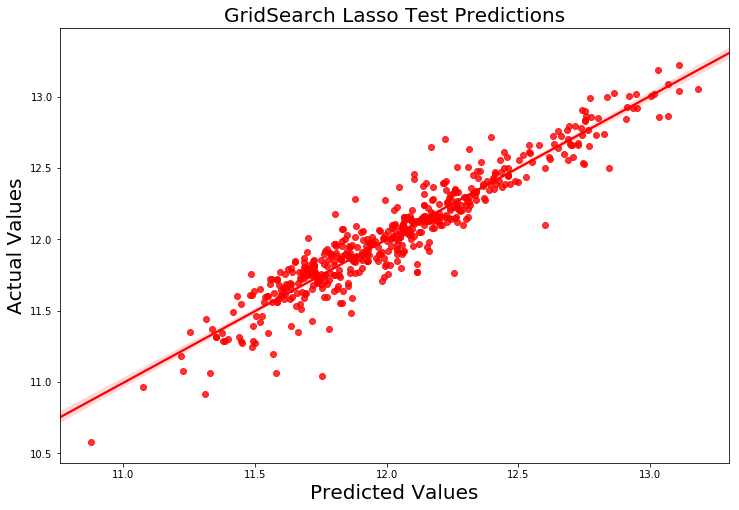

In [185]:
plt.figure(figsize=(12,8))
sns.regplot(gs_lasso_prediction_test, y_test, color='red')
plt.title("GridSearch Lasso Test Predictions", fontsize=20)
plt.xlabel("Predicted Values", fontsize=20)
plt.ylabel("Actual Values", fontsize=20)

In [186]:
columns = train_df.columns
columns = columns[gs_lasso.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_lasso.best_estimator_.named_steps['kbest'].get_support()]

lasso_df = pd.DataFrame(gs_lasso.best_estimator_.named_steps['lasso'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

lasso_df

,Coef Weights
overall_qual,0.106883
year_built,0.043262
year_remod/add,0.038354
gr_liv_area,0.034467
totrms_abvgrd,-0.004270
fireplaces,0.033896
garage_yr_blt,0.000000
garage_area,0.048451
total_area,0.128785
total_bath,0.024216


In [187]:
beta_0 = gs_lasso.best_estimator_.named_steps['lasso'].intercept_

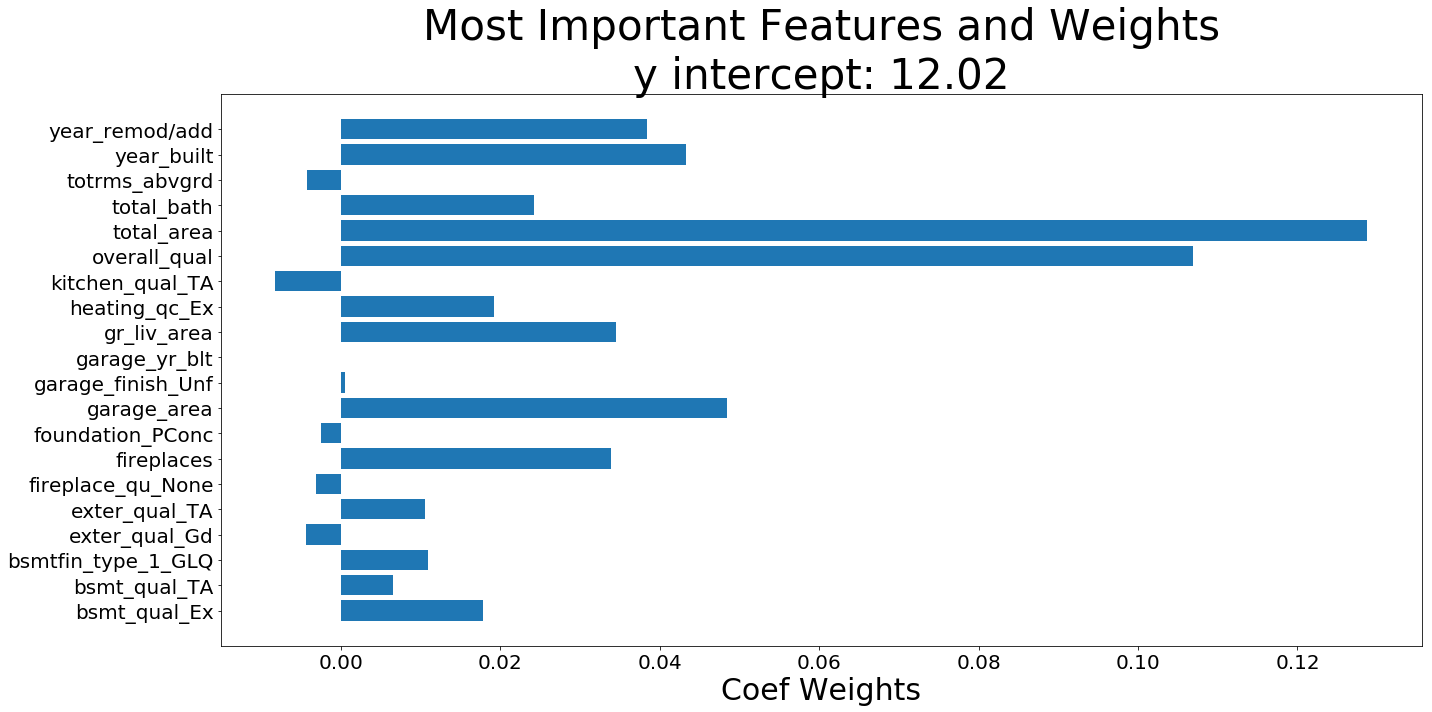

In [188]:
plt.figure(figsize=(20,10))
plt.barh(lasso_df.index, lasso_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=42)
plt.tight_layout()

## Ridge

In [189]:
params = {
    'var_thresh__threshold': [0, .05, .1],
    'kbest__k': [10, 15, 20],
    'ridge__alpha': np.logspace(-3,3,7)}

In [190]:
gs_ridge = GridSearchCV(pipe_ridge, params)

In [191]:
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var_thresh', VarianceThreshold(threshold=0.0)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x10bde8268>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05, 0.1], 'kbest__k': [10, 15, 20], 'ridge__alpha': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [192]:
gs_ridge.score(X_train, y_train), gs_ridge.score(X_test, y_test)

(0.87400210075513018, 0.89331647247334356)

In [193]:
gs_ridge.best_score_

0.8705630930821385

My ridge model scores similar to lasso.

In [194]:
gs_ridge_best_var_thresh = gs_ridge.best_estimator_.named_steps['var_thresh'].get_support()

In [195]:
gs_ridge_best_kbest = gs_ridge.best_estimator_.named_steps['kbest'].get_support()

In [196]:
gs_ridge_best_estimator = gs_ridge.best_estimator_.named_steps['ridge'].coef_

In [197]:
np.sqrt(mean_squared_error(y_test, gs_ridge.best_estimator_.predict(X_test)))

0.134582202132459

In [198]:
gs_ridge_prediction_test = gs_ridge.predict(X_test)

Text(0,0.5,'Actual Values')

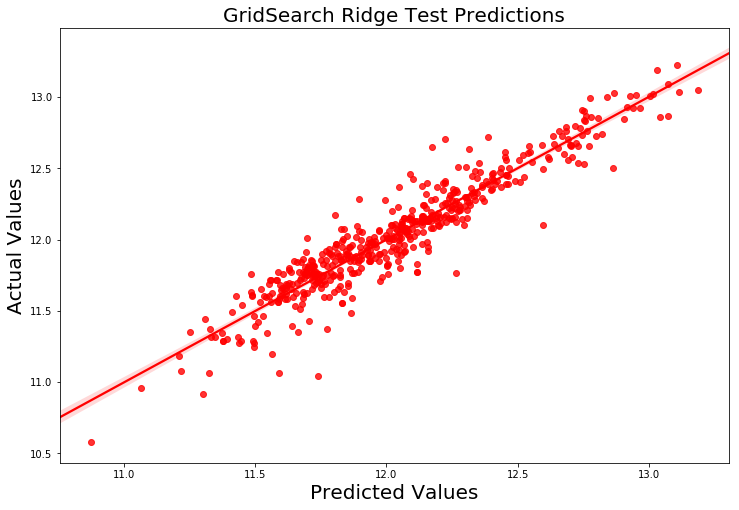

In [199]:
plt.figure(figsize=(12,8))
sns.regplot(gs_ridge_prediction_test, y_test, color='red')
plt.title("GridSearch Ridge Test Predictions", fontsize=20)
plt.xlabel("Predicted Values", fontsize=20)
plt.ylabel("Actual Values", fontsize=20)

In [200]:
columns = train_df.columns
columns = columns[gs_ridge.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs_ridge.best_estimator_.named_steps['kbest'].get_support()]

ridge_df = pd.DataFrame(gs_ridge.best_estimator_.named_steps['ridge'].coef_, 
             index = columns, 
             columns=['Coef Weights'])

ridge_df

,Coef Weights
overall_qual,0.106007
year_built,0.046854
year_remod/add,0.039536
gr_liv_area,0.043097
totrms_abvgrd,-0.009373
fireplaces,0.018848
garage_yr_blt,0.000137
garage_area,0.048603
total_area,0.124558
total_bath,0.024319


In [201]:
beta_0 = gs_ridge.best_estimator_.named_steps['ridge'].intercept_

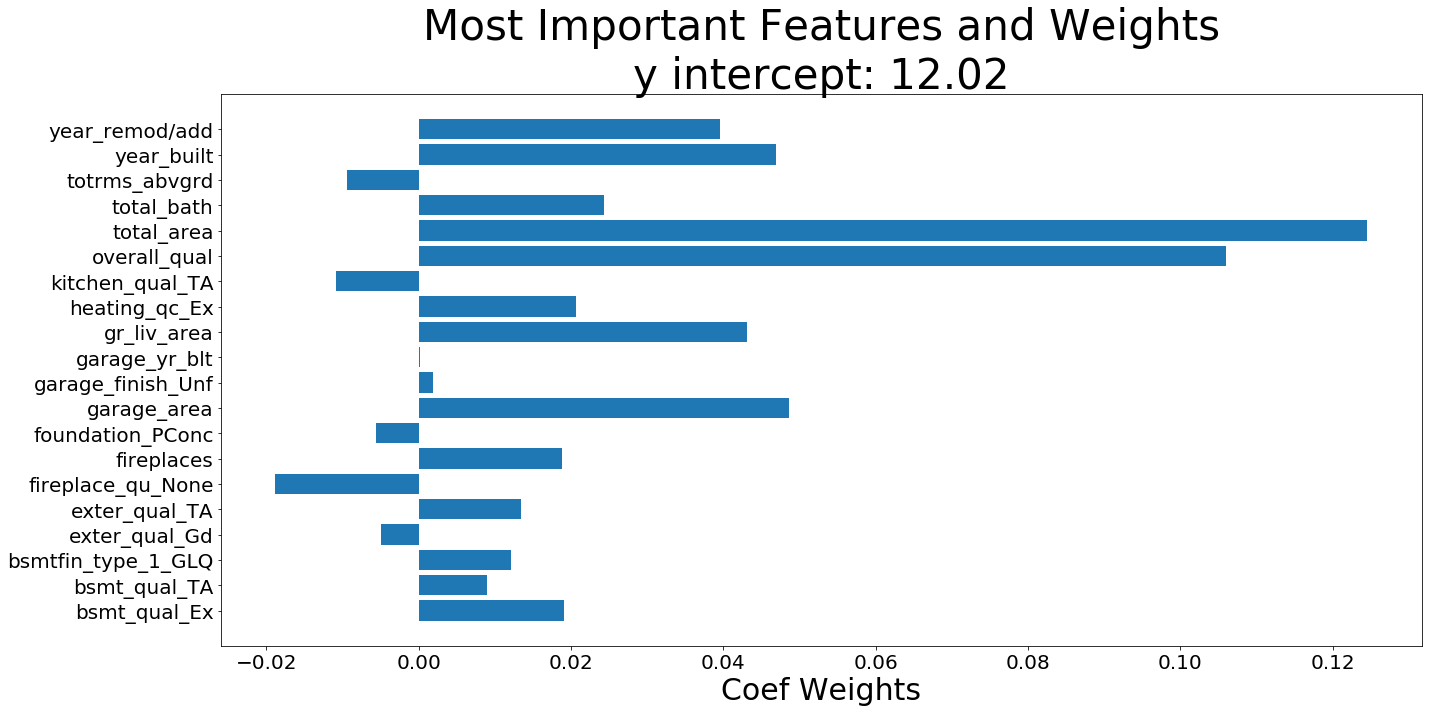

In [202]:
plt.figure(figsize=(20,10))
plt.barh(ridge_df.index, ridge_df['Coef Weights'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Coef Weights', fontsize=30)
plt.title('Most Important Features and Weights\ny intercept: {:0.02f}'.format(beta_0), fontsize=42)
plt.tight_layout()

## Make Predictions

**Lasso Prediction**

In [203]:
pred_lasso_gs = gs_lasso.predict(test_df)

In [204]:
pred_lasso_gs_exp = np.expm1(pred_lasso_gs)

In [205]:
final_lasso_gs_df = pd.DataFrame(pred_lasso_gs_exp, index=test_df.index)

In [206]:
final_lasso_gs_df.columns = ['SalePrice']

In [207]:
final_lasso_gs_df.sort_index(inplace=True)

In [208]:
final_lasso_gs_df.to_csv('./data/final_gs_lasso.csv')

In [209]:
!head ./data/final_gs_lasso.csv

Id,SalePrice
2,124848.08265574471
4,260242.46079753377
6,201347.09086642737
7,204455.25832344173
17,191490.9454326224
18,310670.4434551764
22,168082.87473191222
27,119019.3618952791
31,115085.33364739016


**Linear Prediction**

In [210]:
pred_linreg_gs = gs_linreg.predict(test_df)

In [211]:
pred_linreg_gs_exp = np.expm1(pred_linreg_gs)

In [212]:
final_linreg_gs_df = pd.DataFrame(pred_linreg_gs_exp, index=test_df.index)

In [213]:
final_linreg_gs_df.columns = ['saleprice']

In [214]:
final_linreg_gs_df.sort_index(inplace=True)

In [215]:
final_linreg_gs_df.to_csv('./data/final_gs_linreg.csv')

In [216]:
!head ./data/final_gs_linreg.csv

Id,saleprice
2,121282.8899043063
4,248398.74531216867
6,185189.80973429038
7,221083.20082301617
17,211346.3071769139
18,328649.7530384864
22,170083.76262561165
27,113963.05534800231
31,110446.13512996219


**Ridge Prediction**

In [217]:
pred_ridge_gs = gs_ridge.predict(test_df)

In [218]:
pred_ridge_gs_exp = np.expm1(pred_ridge_gs)

In [219]:
final_ridge_gs_df = pd.DataFrame(pred_ridge_gs_exp, index=test_df.index)

In [220]:
final_ridge_gs_df.columns = ['saleprice']

In [221]:
final_ridge_gs_df.sort_index(inplace=True)

In [222]:
final_ridge_gs_df.to_csv('./data/final_gs_ridge.csv')

In [224]:
!head ./data/final_gs_ridge.csv

Id,saleprice
2,127876.57873550065
4,259451.81256660426
6,202085.49222240076
7,210366.49085234932
17,196367.0467473363
18,309133.9958871072
22,166417.81669951245
27,122501.37398693929
31,118287.72352309621


## Conclusion

OLS regression does not address the problem of multicollinearity.  Therefore, I used the ridge and lasso regularization techniques to deal with this issue.  In ridge regression the weights for attributes cannot exceed a certain constant. Because of this, ridge regression models have significantly less error than OLS regression.  This was proven in my modeling as the ridge regression had a RMSE of 0.13 while the OLS regression had a RMSE score 0.14.  Lasso also deals with multicollinearity by zeroing out the less effective variable.  Lasso performed the best out of my three models and its RMSE was a bit lower than the ridge RMSE.  

I think I can continue to improve my model through better feature engineering and subset selection.  The most important features in all of my models were 'overall_quality', 'total_area', 'gr_liv_area', garage area', 'year_remodele/add' and 'year_built'.  I could run my models with these as the only features to see if it improves their accuracy.  I can also do more feature engineering to try and reduce the number of redundant variables, especially after I got dummies of all my categorical columns.  Finally, I might consider log transforming individual features that had above 0.7 or 0.8 in order to make their distributions closer to normal.